In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

# %matplotlib notebook
# plt.rcParams['figure.figsize'] = [10, 10]


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df

2023-11-02 14:24:28.340372: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 14:24:28.367446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-02 14:24:29.247794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:24:29.251539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 14:24:29.251667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
82278,35428.12,35433.33,35417.33,35433.33,64466.19,1.819762,49,32,42133.640,1.189369,35425.062,17,22332.550,0.630393,35426.227,2023-11-02 00:55:00
82279,35430.06,35432.83,35401.71,35407.59,54114.22,1.527984,45,18,17812.658,0.502967,35417.020,27,36301.566,1.025017,35414.887,2023-11-02 00:56:00
82280,35406.42,35435.61,35405.20,35420.73,58208.62,1.643538,46,31,38531.695,1.087936,35418.523,15,19676.932,0.555602,35415.140,2023-11-02 00:57:00
82281,35419.23,35425.58,35412.05,35425.28,54675.35,1.543666,38,18,24689.611,0.697054,35419.652,20,29985.746,0.846612,35417.883,2023-11-02 00:58:00
82282,35424.93,35446.18,35416.55,35437.51,50273.20,1.418695,39,16,21029.887,0.593440,35438.574,23,29243.316,0.825255,35434.190,2023-11-02 00:59:00


In [53]:
####################################
# Create Dataset with target value
####################################
predicting_days = 10
btc_df_with_target = btc_raw_df
target = btc_raw_df['close'].shift(-predicting_days)
btc_df_with_target['target'] = target
btc_df_with_target.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
82278,35428.12,35433.33,35417.33,35433.33,64466.19,1.819762,49,32,42133.640,1.189369,35425.062,17,22332.550,0.630393,35426.227,2023-11-02 00:55:00,NaN
82279,35430.06,35432.83,35401.71,35407.59,54114.22,1.527984,45,18,17812.658,0.502967,35417.020,27,36301.566,1.025017,35414.887,2023-11-02 00:56:00,NaN
82280,35406.42,35435.61,35405.20,35420.73,58208.62,1.643538,46,31,38531.695,1.087936,35418.523,15,19676.932,0.555602,35415.140,2023-11-02 00:57:00,NaN
82281,35419.23,35425.58,35412.05,35425.28,54675.35,1.543666,38,18,24689.611,0.697054,35419.652,20,29985.746,0.846612,35417.883,2023-11-02 00:58:00,NaN
82282,35424.93,35446.18,35416.55,35437.51,50273.20,1.418695,39,16,21029.887,0.593440,35438.574,23,29243.316,0.825255,35434.190,2023-11-02 00:59:00,NaN


In [4]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
count,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282.000000,82282,82281.000000
mean,28165.782871,28172.676659,28159.072906,28166.304668,29855.604326,1.062233,26.172128,12.857344,14974.745982,0.532643,28166.510185,13.312693,14878.859918,0.529531,28165.661114,2023-10-03 01:34:15.205269760,28166.333120
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000209,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:11:00,24947.410000
25%,26457.425000,26462.715000,26451.712500,26458.157500,15636.735000,0.556562,14.000000,6.000000,7249.437575,0.255752,26458.377500,7.000000,7235.601925,0.255410,26457.389000,2023-09-18 14:07:15,26458.270000
50%,27059.390000,27065.155000,27053.640000,27059.815000,23571.535000,0.827765,21.000000,10.000000,11724.535000,0.415448,27060.114000,11.000000,11753.884500,0.416533,27059.726500,2023-10-03 05:56:30,27059.820000
75%,28383.925000,28391.507500,28376.360000,28384.457500,36389.652500,1.307089,32.000000,16.000000,18561.642750,0.663789,28384.778750,16.000000,18514.605000,0.662319,28383.278750,2023-10-18 03:30:45,28384.460000
max,35595.600000,35638.560000,35572.350000,35592.930000,601811.300000,22.802782,887.000000,613.000000,475487.720000,16.123856,35608.996000,376.000000,411043.200000,15.579352,35606.535000,2023-11-02 00:59:00,35592.930000
std,2772.847865,2775.557847,2770.328262,2773.074987,24866.276860,0.851659,20.487957,11.465037,13541.925897,0.465072,2773.207119,11.307037,13199.506615,0.455445,2772.757865,NaN,2773.079829


In [54]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,target
82278,35428.12,35433.33,35417.33,35433.33,64466.19,1.819762,49,32,42133.640,1.189369,35425.062,17,22332.550,0.630393,35426.227,NaN
82279,35430.06,35432.83,35401.71,35407.59,54114.22,1.527984,45,18,17812.658,0.502967,35417.020,27,36301.566,1.025017,35414.887,NaN
82280,35406.42,35435.61,35405.20,35420.73,58208.62,1.643538,46,31,38531.695,1.087936,35418.523,15,19676.932,0.555602,35415.140,NaN
82281,35419.23,35425.58,35412.05,35425.28,54675.35,1.543666,38,18,24689.611,0.697054,35419.652,20,29985.746,0.846612,35417.883,NaN
82282,35424.93,35446.18,35416.55,35437.51,50273.20,1.418695,39,16,21029.887,0.593440,35438.574,23,29243.316,0.825255,35434.190,NaN


In [55]:
dataset_raw_df[['close','target']].tail()

,close,target
82278,35433.33,NaN
82279,35407.59,NaN
82280,35420.73,NaN
82281,35425.28,NaN
82282,35437.51,NaN


In [56]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close',
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(82282, 4)


array([[0.08236596, 0.07775363, 0.08413046, 0.08246004],
       [0.08248335, 0.07775363, 0.08460282, 0.08249386],
       [0.08246175, 0.07730132, 0.08423939, 0.08248728],
       ...,
       [0.98223363, 0.9809154 , 0.98430325, 0.98382418],
       [0.98343665, 0.97997222, 0.98494652, 0.98425159],
       [0.98397195, 0.98190936, 0.98536911, 0.98540043]])

In [57]:
sc_target = MinMaxScaler(feature_range = (0,1))
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df['target'].to_frame())
print(dataset_target_scaled.shape)
dataset_target_scaled

(82282, 1)


array([[0.08210308],
       [0.08247225],
       [0.08250419],
       ...,
       [       nan],
       [       nan],
       [       nan]])

In [58]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 60
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],
         dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i],
         dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (65765, 63)
X_test shape (16457, 63)


In [ ]:
# Create a Sequential model
regressor = Sequential()

# regressor.add(LSTM(units = 64,return_sequences = True,input_shape = (X_train.shape[1],1)))
# regressor.add(Dropout(0.5))
# regressor.add(LSTM(units = 64,return_sequences = True))
# regressor.add(Dropout(0.5))
# regressor.add(LSTM(units = 50,return_sequences = True))
# regressor.add(Dropout(0.5))
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.5))
# regressor.add(Dense(units = 1))

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'Adagrad',loss = 'mean_squared_error')
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 500, 
                        batch_size = 32,
                        validation_split=0.3, 
                        shuffle=True, 
                        callbacks=[callback])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 63, 1024)          4202496   
                                                                 
 dropout_14 (Dropout)        (None, 63, 1024)          0         
                                                                 
 lstm_24 (LSTM)              (None, 1024)              8392704   
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 12596225 (48.05 MB)
Trainable params: 12596225 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
1439/1439 [==============================] - 14s 9ms/step - loss: 0.0036 - val_loss: 0.0130
Epoch 2/500
1439/1439 [================

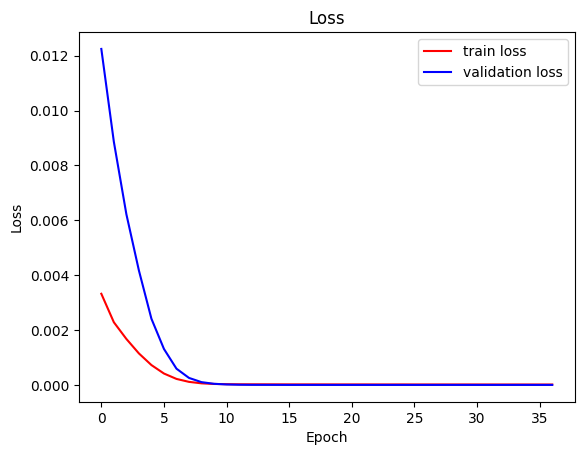

In [49]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

515/515 [==============================] - 2s 3ms/step
predicted_price shape: (16456, 1)
real_price shape: (16456, 1)


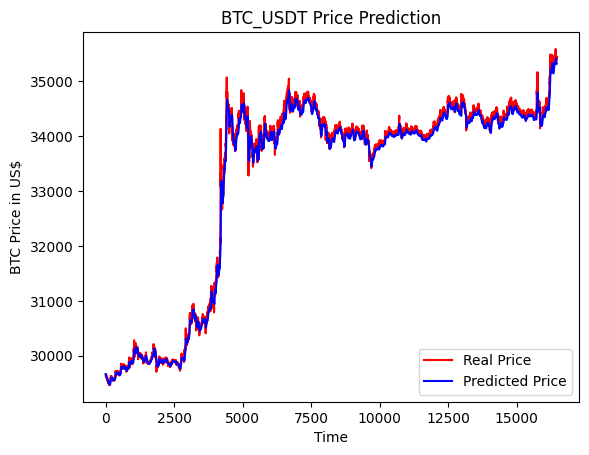

In [50]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_days]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_days]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

515/515 [==============================] - 2s 3ms/step
predicted_price shape: (16456, 1)
real_price shape: (16456, 1)


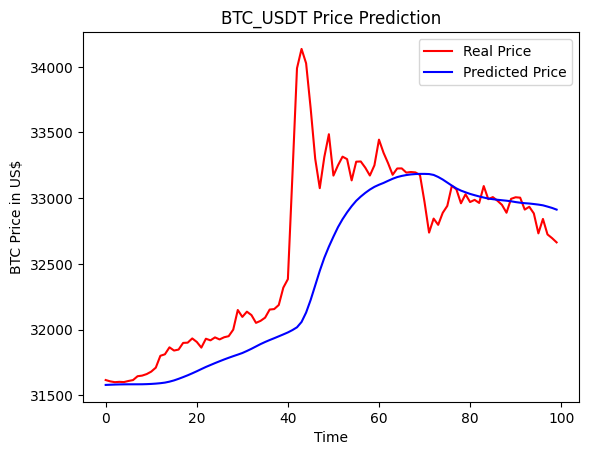

In [51]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_days]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_days]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[4150:4250], color = 'red', label = 'Real Price')
plt.plot(predicted_price[4150:4250], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [52]:
mse = metrics.mean_squared_error(real_price.reshape(real_price.shape[0]),
                   predicted_price.reshape(predicted_price.shape[0]))
print('mse:',mse)

mse: 9098.936167769874
